
# Описание проекта
Вы решили открыть небольшое кафе 
в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов.
За исходные мы принимаем как данность пожелание заказчика :
- фиксированный тип(рынок) - кафе
- фиксированный формат - несетевой

## Подготовка данных к анализу

### Выгрузка данных

In [1]:
# загружаем все библиотеки, нужные дял дальнейшей работы 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from numpy import median

df = pd.read_csv('/datasets/rest_data.csv')# импортируем файл csv c заведениями общественного питания Москвы
df.info()# проверяем данные на форматы
display(df.head())# выводим 5 топ строк


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


#### Вывод
     - выгрузила данные по заведениям общественного питания Москвы
     - проверила заголовки и форматы

### Проверка форматов, дубликатов и ошибок в данных

In [2]:
# проверяем на наличие отрицательных значений

def find_num_cols(df):
    numerical_columns = [c for c in df.columns if df[c].dtype.name =='int64'] # выбираем только столбцы с количественными данными	
    return numerical_columns

numeric = find_num_cols(df)# список столбцов с количественными данными присваивается переменной 'numeric'
for i in numeric:
    df[i] = df[i].abs()
print()
        
# проверка на дубликаты
print('Кол-во дубликатов: ',df.duplicated().sum())

# проверяем категориальные столбцы на неочевидные пропукси и дубликаты
def find_cat_cols(df):
    categorial_columns = [c for c in df.columns if df[c].dtype.name == 'object'] #выбираем только столбцы с категориальными данными
    return categorial_columns

categorial = find_cat_cols(df)
for i in categorial:
    print(df[i].unique())      
display(df['object_name'].unique())        


Кол-во дубликатов:  0
['СМЕТАНА' 'Родник' 'Кафе «Академия»' ... 'Бар Мята Lounge'
 'Мята Lounge Октябрьская' 'Кальянная «Мята Lounge»']
['нет' 'да']
['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']
['город Москва, улица Егора Абакумова, дом 9'
 'город Москва, улица Талалихина, дом 2/1, корпус 1'
 'город Москва, Абельмановская улица, дом 6' ...
 'город Москва, Салтыковская улица, дом 7Г'
 'город Москва, Осенний бульвар, дом 9'
 'город Москва, улица Новый Арбат, дом 13']


array(['СМЕТАНА', 'Родник', 'Кафе «Академия»', ..., 'Бар Мята Lounge',
       'Мята Lounge Октябрьская', 'Кальянная «Мята Lounge»'], dtype=object)

#### Вывод
     - проверка на дубликаты
     - проверяем количественные данные на наличие отрицательных значений
     - проверяем категориальные данные на наличие неочевидных  пропусков в дубликаты

### Проверка на наличие выбросов и очистка данных

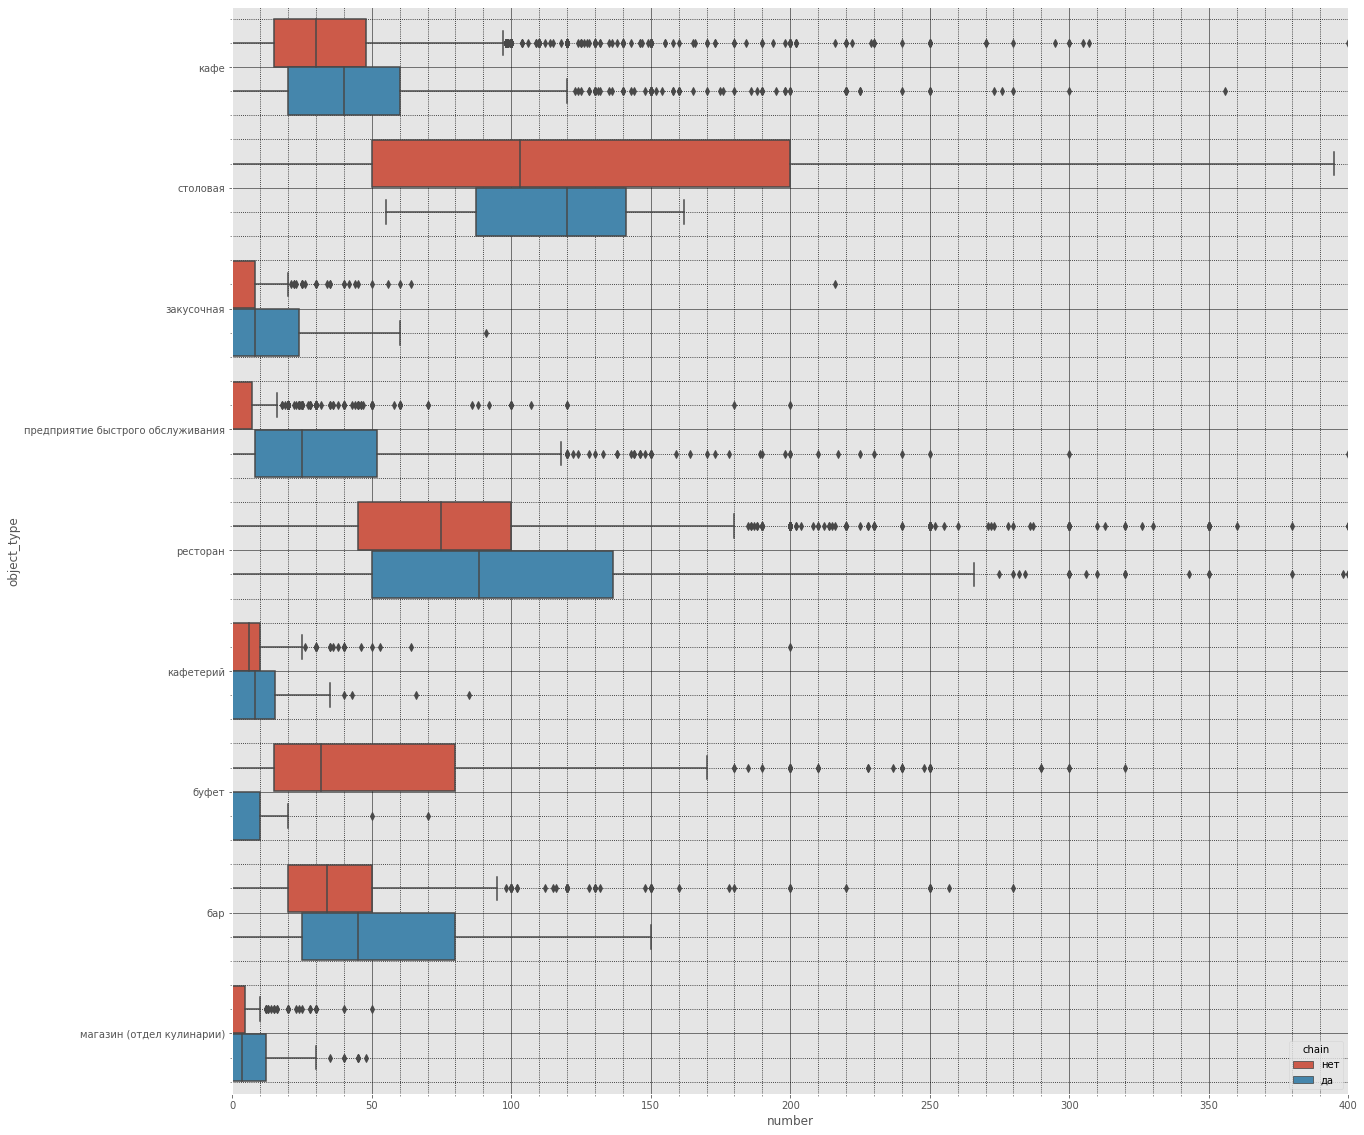

In [3]:
# проверка на наличие выбросов
# создаем boxplots по видам общественного питания
plt.style.use('ggplot')
plt.figure(figsize=(20,20))
sns.boxplot(x='number',y='object_type',data=df, hue='chain')
plt.xlim(0,400)
plt.minorticks_on()
plt.grid('both',which='major',
        color = 'k', 
        linewidth = 0.5)
plt.grid('both',which='minor', 
        color = 'k', 
        linestyle = ':')

# судя по графикам,некоторые виды общественного питания обходятся без посадочных мест, это вполне возможно
# причин рассматривать их как ошибки или выбросы нет


In [4]:
# очищаем данные от выбросов:
# для несетей
limits_nochain ={"кафе":95,"столовая":395,"закусочная":20,"предприятие быстрого обслуживания":18,"ресторан":180,
                 "кафетерий":25,"буфет":170 ,"бар":95,"магазин (отдел кулинарии)":10}
def slice_nochain(row):
    for key in limits_nochain:
        if row['object_type']== key:
            if row['number']<=limits_nochain[key]:
                return 'ok'
            
# для сетей           
limits_chain ={"кафе":120,"столовая":160,"закусочная":60,"предприятие быстрого обслуживания":118,"ресторан":265,
                  "кафетерий":35,"буфет":20 ,"бар":150,"магазин (отдел кулинарии)":30}
def slice_chain(row):
    for key in limits_chain:
        if row['object_type']== key:
            if row['number']<=limits_chain[key]:
                return 'ok' 

# создание срезов,очищенных от выбросов 
df_nochain = df.query('chain=="нет"')
df_chain = df.query('chain=="да"')
df_nochain['slicer'] = df_nochain.apply(slice_nochain,axis=1)    
df_chain['slicer'] = df_chain.apply(slice_chain,axis=1)

frames = [df_nochain,df_chain]
df_actual = pd.concat(frames)
df_actual = df_actual.query('slicer=="ok"')
df_actual = df_actual.drop(columns=['slicer'])
display(df_actual.head())

/tmp/ipykernel_98/2638874023.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nochain['slicer'] = df_nochain.apply(slice_nochain,axis=1)
/tmp/ipykernel_98/2638874023.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chain['slicer'] = df_chain.apply(slice_chain,axis=1)


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240


#### Вывод
     - проверили исходные данные на наличие выбросов при помощи ящика с усами в  разрезе типов общественного питания
     - произвели очистку

## Анализ данных

### Соотношение видов объектов общественного питания по количеству

<AxesSubplot:title={'center':'Соотношение видов объектов общественного питания по количеству'}>

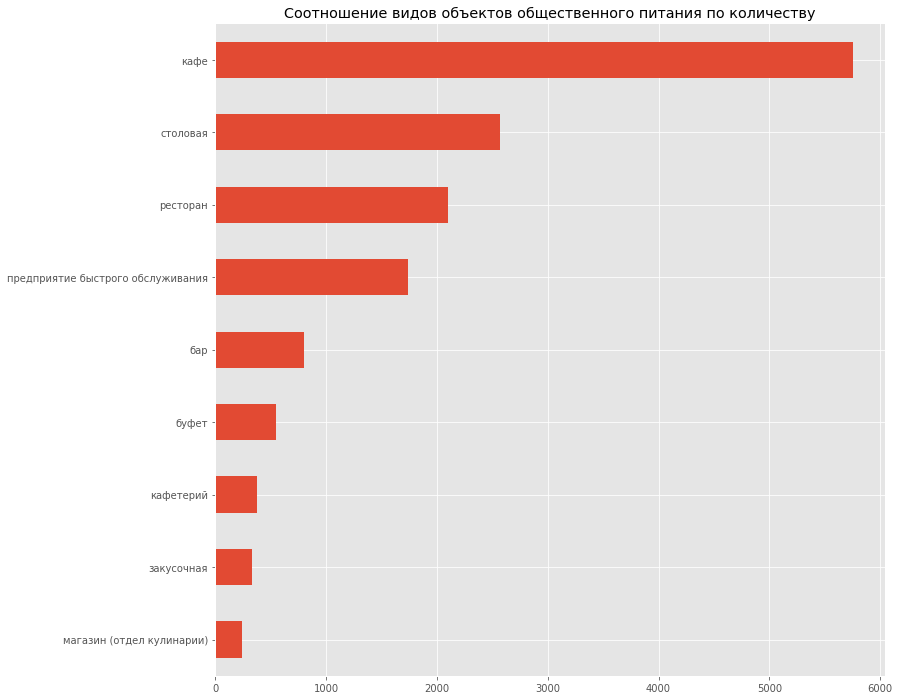

In [5]:
# соотношение видов объектов общественного питания по количеству
df_actual['object_type'].value_counts().sort_values().plot(kind='barh',figsize=(12,12),title='Соотношение видов объектов общественного питания по количеству')


#### Вывод
     - Самый распространенный вид общественного питания - кафе. Далее идут в порядке убывания с значительным отрывом:
     - столовые, рестораны, предприятиы быстрого обслуживания

### Cоотношение сетевых и несетевых заведений по количеству

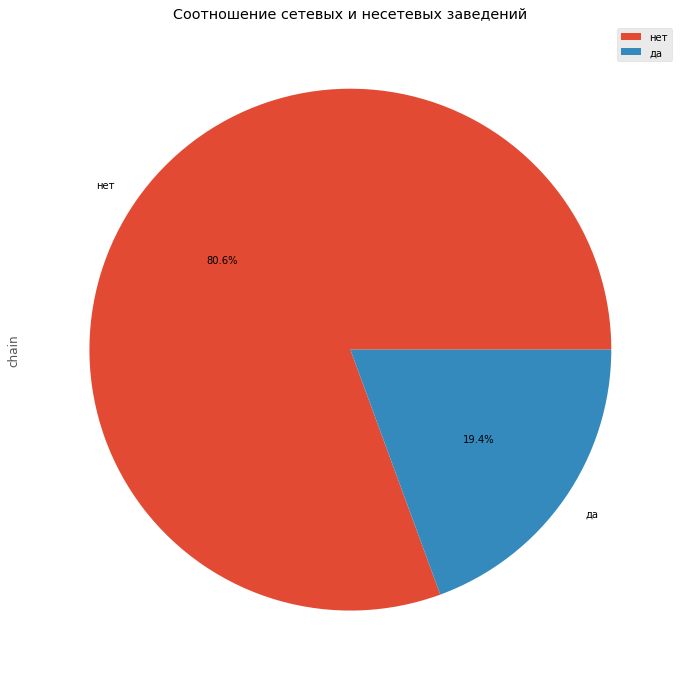

In [6]:
# соотношение сетевых и несетевых заведений по количеству
plt.style.use('ggplot') # выбираем стиль из библиотеки matplotlip

# строим кругову диаграмму с долями сетевых и нет заведений
df_actual['chain'].value_counts().plot(kind='pie',figsize=(12,12),autopct='%1.1f%%',title='Соотношение сетевых и несетевых заведений')
plt.legend()

#### Вывод
     - Сетевые заведения занимают лишь 19% от общего числа заведений Москвы.

### Для какого вида объекта общественного питания характерно сетевое распространение

<AxesSubplot:title={'center':'Доля сетевых и несетевых заведений по каждому типу общественного питания'}, xlabel='object_type'>

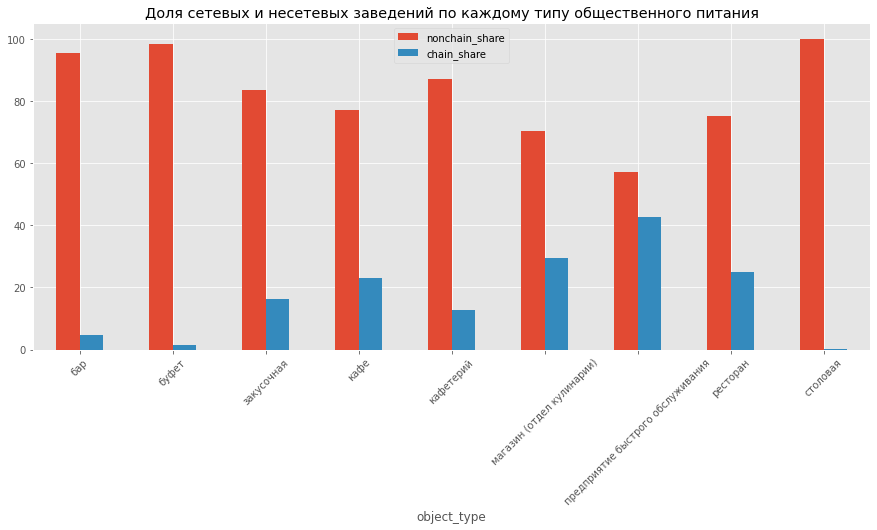

In [7]:
# для какого вида объекта общественного питания характерно сетевое распространение

# cтроим сводную таблицу с данными доли сети и несетей от общего кол-ва точек по каждому виду
non_chain = df_actual.pivot_table(index='object_type',columns=['chain'],values='id',aggfunc='count').reset_index()

non_chain.columns = ['object_type','chain','nonchain']
non_chain['total'] = non_chain['chain']  + non_chain['nonchain']
non_chain['nonchain_share'] = round(non_chain['nonchain']/non_chain['total']*100,2)
non_chain['chain_share'] = round(non_chain['chain']/non_chain['total']*100,2)

non_chain_shares = non_chain[['object_type','nonchain_share','chain_share',]]
# строим барплот с данными по доли сетей для каждого вида общественного питания
non_chain_shares.plot.bar(x='object_type',rot=45,figsize=(15,6),title='Доля сетевых и несетевых заведений по каждому типу общественного питания')


#### Вывод
     Сетевое распространение характерно для предприятий быстрого обслуживания, далее с небольшим отличие по доли сетей идут          магазины(отдел кулинария),ресторанов и кафе

### Сетевые заведения: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

Text(0.5, 1.0, 'Среднее число посадочных мест в сетевых и несетевых форматах')

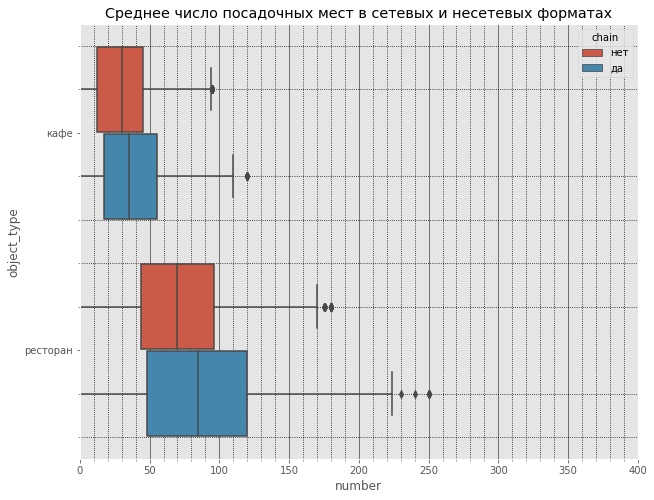

In [8]:
# Выбираем для анализа  рынки(типы объектов общественного питания)схожие по качеству с целевым (кафе) рынком:

# 1.востребованности объектов питания (пункт 2.1). Кроме того,совсем маленькие рынки не будет показательны для соотношения.
# 2.миксу сетевых и несетевых форматов (пункт 2.2) с кафе.

# Анализируем соотношение параметра-среднее кол-во посадочных мест для 2-х форматов сетевых и несетевых на примере выбранных
# рынков(типов) отдельно для каждого типа.Важно убедиться, что на соотношение не оказала специфика параметра 
# для данного типа общественного питания. Например, 1 тип имеют очень высокие значения данного параметра, а прочие
# два типа-нет. Тогда если данный тип будет в большей мере представлен в одном из форматов нежели в другом, то это исказит распределение.
# + нам нужно убедиться на нескольких рынках, что соотношение обусловлено именно форматом(сетевой/нет) и сохраняется для всех рынков.

# фильтруем исходные данные по выбранным рынкам
df_actual_type = df_actual.query('object_type in ("кафе","ресторан")')

# строим бохплоты
plt.figure(figsize=(10,8))
plt.grid()
plt.minorticks_on()
plt.grid('both',which='major',
        color = 'k', 
        linewidth = 0.5)
plt.grid('both',which='minor', 
        color = 'k', 
        linestyle = ':')

plt.xlim(0,400)

sns.boxplot(x='number',y='object_type', data=df_actual_type, hue='chain').set_title('Среднее число посадочных мест в сетевых и несетевых форматах')

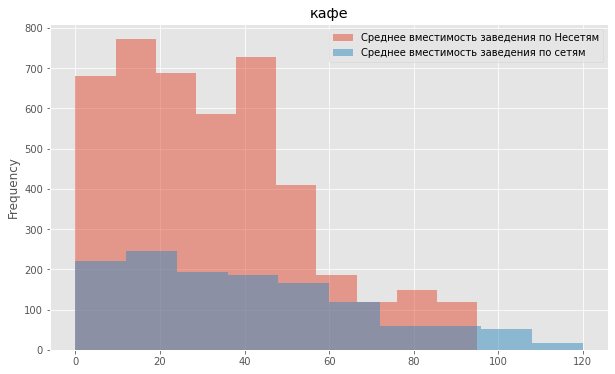

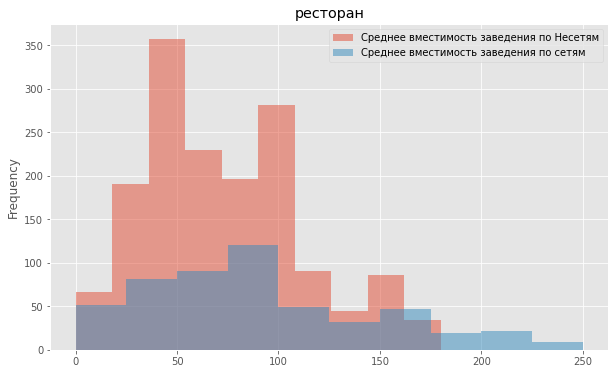

In [9]:

parametres= df_actual['object_type'].unique()
parametres = ['кафе','ресторан'] # выделяем виды общественного питания, где представлены сети

# строим гистограммы по 3-м видам общественного питания в сравнении сетевых и несетевых точек
for parametr in parametres:
    df_number = df_actual[df_actual['object_type']==parametr].pivot_table(index=['id','chain'], values='number',aggfunc='median').reset_index(1)
    df_number_chain = df_number[df_number['chain']=='да']
    df_number_nochain = df_number[df_number['chain']=='нет']
    ax1=df_number_nochain.plot(kind='hist',y='number',alpha=0.5,bins=10,label='Среднее вместимость заведения по Несетям')
    df_number_chain.plot(kind='hist',y='number',alpha=0.5,bins=10,figsize=(10,6),label='Среднее вместимость заведения по сетям',ax=ax1)
    plt.title(parametr)
    plt.show()


#### Вывод
     - Проведенный анализ позволяет сделать вывод, сетевой формат представлен меньшим кол-вом заведений с большим кол-вом            посадочных мест нежели несетевой

### Среднее кол-во посадочных мест по каждому виду общественного  питания

Text(0.5, 1.0, 'Среднее кол-во посадочных мест по типам общественного питания')

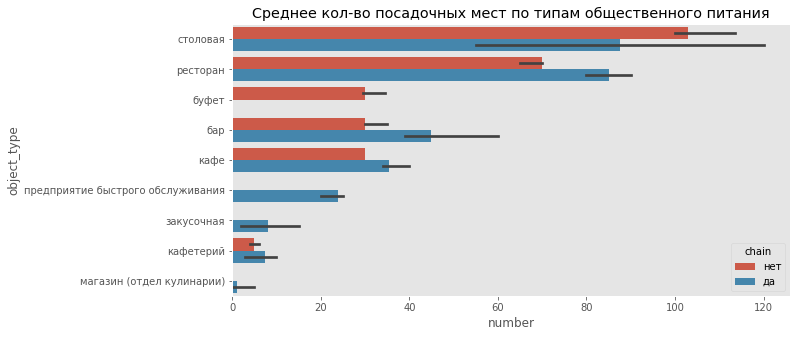

In [10]:
# среднее кол-во посадочных мест для каждого вида общественного питания

#wo_number = len(df[(df['object_type']=='закусочная')&(df['number']==0)])
#all_number = len(df[df['object_type']=='закусочная'])
#print(wo_number/all_number)# почти 50% закусочных без мест

# строим график распределения среднего кол-ва посадочных мест
plt.figure(figsize=(10,5))
plt.xlim=(0,100)
plt.grid()
df_actual = df_actual.sort_values(by='number',ascending=False)
sns.barplot(x='number', y='object_type',data=df_actual,hue='chain', estimator=median).set_title('Среднее кол-во посадочных мест по типам общественного питания')



#### Выводы
    - Среднее кол-во посадочных мест в несетевых  кофейнях 30 против 35 в сетевых
    - По кафе наименьший разрыв между сетевыми и нет заведениями
    - Наибольшее кол-во посадочных мест среди на заведение предоставляют столовые.
    - Причем, в этом сегменте по кол-ву посадочных мест лидирует именно несетевой вормат, так как данный формат является           господствующим для этого типа, а сетевой фактически не представлен.
    -Это лишний раз подтверждает влияние доли на соотношение характеристик форматов.

### Выделение информации об улице из address

In [11]:
# выделите в отдельный столбец информацию об улице из столбца address 
df_actual['street'] = df_actual['address'].str.split(',')
marks= ['улица','шоссе','набережная','проспект','проезд']
def check(x):
    for i in range(len(x)):
        try:
            for j in range(len(marks)):
                if marks[j] in  x[i]:
                    return x[i]
        except:
            pass
        
df_actual['street_new'] = df_actual['street'].apply(check)

pd.set_option('max_colwidth', 300)# сипользуем, чтобы расширить столбцы и увидеть первоначальный адрес улицы
display(df_actual.head())


,id,object_name,chain,object_type,address,number,street,street_new
2446,28677,ГП КП МГАИ,нет,столовая,"город Москва, улица Константина Царёва, дом 16",395,"[город Москва, улица Константина Царёва, дом 16]",улица Константина Царёва
8568,136431,Столовая на базе ГБОУ Школа № 2083. ДО «Журавушка»,нет,столовая,"город Москва, поселение Рязановское, посёлок Фабрики имени 1 Мая, дом 45А",371,"[город Москва, поселение Рязановское, посёлок Фабрики имени 1 Мая, дом 45А]",None
6228,29451,ГОУ ЦО № 2006,нет,столовая,"город Москва, улица Грина, дом 18, корпус 3, строение 1",362,"[город Москва, улица Грина, дом 18, корпус 3, строение 1]",улица Грина
7353,28989,Столовая «Школа 983 КДП»,нет,столовая,"город Москва, Кантемировская улица, дом 22, корпус 4",360,"[город Москва, Кантемировская улица, дом 22, корпус 4]",Кантемировская улица
4790,28912,СТОЛОВАЯ ПРИ ГОУ СОШ № 1040,нет,столовая,"город Москва, Батайский проезд, дом 47",360,"[город Москва, Батайский проезд, дом 47]",Батайский проезд


In [12]:
# выделите в отдельный столбец информацию об улице из столбца address 
df_actual['street'] = df_actual['address'].str.split(',')
df_actual['street_x'] = df_actual['street'].str[1]
df_actual['street_y'] = df_actual['street'].str[2]

#display(df_actual['street_x'].value_counts())# смотрим полученные улицы,обнаруживаем оставшийся город

# проверка, почему выпадает Зеленоград в адресах
#for i in range(len(df)):
    #if 'Зеленоград' in df['address'][i]:
       # print(df['address'][i])
        
# прописываем функцию, чтобы сравнить адреса в двух столбцах и выбрать тот, что без города
def clean(row):
    if 'город' in row['street_x']:
        return row['street_y']
    elif 'поселение' in row['street_x']:
        return row['street_y']
    else:
        return row['street_x']
    
df_actual['street_clean'] = df_actual.apply(clean,axis=1)

df_actual = df_actual.drop(columns=['street_x','street','street_y'])

display(df_actual['street_clean'].value_counts())


 Профсоюзная улица           173
 проспект Мира               170
 Ленинградский проспект      163
 Пресненская набережная      155
 Варшавское шоссе            150
                            ... 
 улица Крутицкий Вал           1
 Стрелецкая улица              1
 Стандартная улица             1
 Карельский бульвар            1
 1-й Люсиновский переулок      1
Name: street_clean, Length: 2114, dtype: int64

Комментарии к выбранному методу:

Исходим из того, что нам в дальнейшем нужно будет определить топовые улицы либо улицы с 1 заведением.
    
Первые я просмотрела,последние, единичные, вряд ли туда попадет целый город или поселок. Чтобы выделить слова-маркеры тоже нужно понять-какие именно. По факту нас интересует не только улица с названием "улица". В целом таких маркеров предположительно меньше, чем маркеров с адресами(улицами).
    
Для случаев, что я обнаружила, просмотрев те, что с большим числов заведенийгде-то до 45 штук, таких как Зеленоград и поселок, я использовала apply. 


#### Вывод
  - Данные об улице расположения заведения общественного питания выделены в отдельный столбец и отсортированы по убыванию

### Топ-10 улиц по количеству объектов общественного питания

In [13]:
# воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы

# топ 10 улиц по кол-ву объектов общественного питания
df_street_top = df_actual['street_clean'].value_counts().head(10).reset_index()
df_street_top.columns = ['street_clean','count'] # переименовываем столбцы
df_street_top['street_clean'] = df_street_top['street_clean'].str.lstrip()# удаляем ненужные пропусков
display(df_street_top)


,street_clean,count
0,Профсоюзная улица,173
1,проспект Мира,170
2,Ленинградский проспект,163
3,Пресненская набережная,155
4,Варшавское шоссе,150
5,Ленинский проспект,137
6,проспект Вернадского,120
7,Кутузовский проспект,102
8,Каширское шоссе,101
9,Ходынский бульвар,100


In [14]:
# выгружаем файл из внешнего источника
dictionary = pd.read_csv('https://drive.google.com/uc?export=download&id=10HNxLhllKVu0QFP0QlUsdFDvd-h0dqGK')
#display(dictionary)

# преобразуем заголовки столбцов
dictionary = dictionary.rename(columns={'streetname':'street_clean'})
dictionary = dictionary[['street_clean','area']]
display(dictionary)


,street_clean,area
0,Выставочный переулок,Пресненский район
1,улица Гашека,Пресненский район
2,Большая Никитская улица,Пресненский район
3,Глубокий переулок,Пресненский район
4,Большой Гнездниковский переулок,Пресненский район
...,...,...
4393,Вознесенский проезд,Пресненский район
4394,Волков переулок,Пресненский район
4395,Поварская улица,Пресненский район
4396,Кудринская площадь,Пресненский район


In [15]:
# объединяем фреймы с данными по топовым улицам и соотвктствующим регионом
df_street_top_region = df_street_top.merge(dictionary,on='street_clean',how='left',suffixes=('street_clean','street_clean'))
display(df_street_top_region)


,street_clean,count,area
0,Профсоюзная улица,173,Академический район
1,Профсоюзная улица,173,Район Черемушки
2,Профсоюзная улица,173,Район Ясенево
3,Профсоюзная улица,173,Район Коньково
4,Профсоюзная улица,173,Обручевский район
5,Профсоюзная улица,173,Район Теплый Стан
6,проспект Мира,170,Алексеевский район
7,проспект Мира,170,Ярославский Район
8,проспект Мира,170,Район Марьина роща
9,проспект Мира,170,Останкинский район


In [16]:
# делаем срез только по топовым улицам на общем датафрейме
df_actual['street_clean'] = df_actual['street_clean'].str.lstrip()
df_actual_top = df_actual[df_actual['street_clean'].isin(df_street_top_region['street_clean'])]
df_actual_top = df_actual_top.merge(df_street_top_region,on='street_clean',how='left',suffixes=('street_clean','street_clean'))
df_actual_top = df_actual_top.drop(columns=['count'])
display(df_actual_top)

,id,object_name,chain,object_type,address,number,street_new,street_clean,area
0,19720,Столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, строение 1",328,проспект Вернадского,проспект Вернадского,Район Проспект Вернадского
1,19720,Столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, строение 1",328,проспект Вернадского,проспект Вернадского,Район Раменки
2,19720,Столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, строение 1",328,проспект Вернадского,проспект Вернадского,Район Тропарево-Никулино
3,19720,Столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, строение 1",328,проспект Вернадского,проспект Вернадского,Район Гагаринский
4,19720,Столовая,нет,столовая,"город Москва, проспект Вернадского, дом 82, строение 1",328,проспект Вернадского,проспект Вернадского,Ломоносовский район
...,...,...,...,...,...,...,...,...,...
6634,203845,БАК БО,нет,кафе,"город Москва, Ленинский проспект, дом 109",0,Ленинский проспект,Ленинский проспект,Район Якиманка
6635,221385,МИЛТИ готовые блюда для здорового питания,нет,кафетерий,"город Москва, Каширское шоссе, дом 3, корпус 2, строение 9",0,Каширское шоссе,Каширское шоссе,Район Москворечье-Сабурово
6636,221385,МИЛТИ готовые блюда для здорового питания,нет,кафетерий,"город Москва, Каширское шоссе, дом 3, корпус 2, строение 9",0,Каширское шоссе,Каширское шоссе,Район Нагатино-Садовники
6637,221385,МИЛТИ готовые блюда для здорового питания,нет,кафетерий,"город Москва, Каширское шоссе, дом 3, корпус 2, строение 9",0,Каширское шоссе,Каширское шоссе,Район Орехово-Борисово Южное


#### Вывод
   - Выделили улицы Москвы с наибольшим кол-во заведений общественного питания и соответствующие им регионы
   


### Число улиц с одним объектом общественного питания. 

In [27]:
# выделяем число улиц с 1 объектом общественного питания
df_actual_street = df_actual.groupby('street_clean').agg({'street_clean':'count'})
df_actual_street.columns = ['count']
one_per_street = df_actual_street[df_actual_street['count']==1].reset_index()
one_per_street_len = len(one_per_street)

print('Число улиц с 1-м объектом общественного питания равно: {}'.format(one_per_street_len))
display(one_per_street)

Число улиц с 1-м объектом общественного питания равно: 719


,street_clean,count
0,1-й Балтийский переулок,1
1,1-й Басманный переулок,1
2,1-й Ботанический проезд,1
3,1-й Вешняковский проезд,1
4,1-й Голутвинский переулок,1
...,...,...
714,улица Шеногина,1
715,улица Шумилова,1
716,улица Шумкина,1
717,улица Щорса,1


In [28]:
# объединяем фреймы с данными по свободным улицам и соответствующим регионом
df_street_bottom_region = one_per_street.merge(dictionary,on='street_clean',how='left',suffixes=('street_clean','street_clean'))
display(df_street_bottom_region)


,street_clean,count,area
0,1-й Балтийский переулок,1,Район Аэропорт
1,1-й Басманный переулок,1,Басманный район
2,1-й Басманный переулок,1,Красносельский район
3,1-й Ботанический проезд,1,Район Свиблово
4,1-й Вешняковский проезд,1,Рязанский район
...,...,...,...
762,улица Шеногина,1,Район Хорошево-Мневники
763,улица Шумилова,1,Район Кузьминки
764,улица Шумкина,1,Район Сокольники
765,улица Щорса,1,Район Солнцево


In [29]:
# делаем срез только по свободным улицам на общем датафрейме
df_actual_bottom = df_actual[df_actual['street_clean'].isin(df_street_bottom_region['street_clean'])]
df_actual_bottom = df_actual_bottom.merge(df_street_bottom_region,on='street_clean',how='left',suffixes=('street_clean','street_clean'))
df_actual_bottom = df_actual_bottom.drop(columns=['count']).dropna()
display(df_actual_bottom)

,id,object_name,chain,object_type,address,number,street_new,street_clean,area
0,144426,ГБОУ Школа № 1499,нет,столовая,"город Москва, Ростокинская улица, дом 3",330,Ростокинская улица,Ростокинская улица,Район Ростокино
1,23669,Школа 1012,нет,столовая,"город Москва, Родниковая улица, дом 20, корпус 1",320,Родниковая улица,Родниковая улица,Район Солнцево
2,27436,ШКОЛА 1381,нет,столовая,"город Москва, Янтарный проезд, дом 2",300,Янтарный проезд,Янтарный проезд,Лосиноостровский район
4,29008,ЦО №1450 «КОМБИНАТ ДОШКОЛЬНОГО ПИТАНИЯ»,нет,столовая,"город Москва, Фруктовая улица, дом 9",300,Фруктовая улица,Фруктовая улица,Нагорный район
5,29008,ЦО №1450 «КОМБИНАТ ДОШКОЛЬНОГО ПИТАНИЯ»,нет,столовая,"город Москва, Фруктовая улица, дом 9",300,Фруктовая улица,Фруктовая улица,Район Зюзино
...,...,...,...,...,...,...,...,...,...
759,179098,Выпечка,нет,магазин (отдел кулинарии),"город Москва, 4-я Гражданская улица, дом 43, корпус 2",0,4-я Гражданская улица,4-я Гражданская улица,Район Богородское
760,184359,Донер Кебаб,нет,предприятие быстрого обслуживания,"город Москва, улица Медиков, дом 16",0,улица Медиков,улица Медиков,Район Царицыно
762,189611,"Выпечка,шаурма",нет,предприятие быстрого обслуживания,"город Москва, улица Академика Комарова, дом 5А",0,улица Академика Комарова,улица Академика Комарова,Район Марфино
764,150823,ГБОУ Школа №480 им.В.В. Талалихина,нет,столовая,"город Москва, Стройковская улица, дом 5",0,Стройковская улица,Стройковская улица,Таганский район


#### Вывод
    = Выделили улицы Москвы с 1 заведением общественного питания и соответствующие им регионы

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

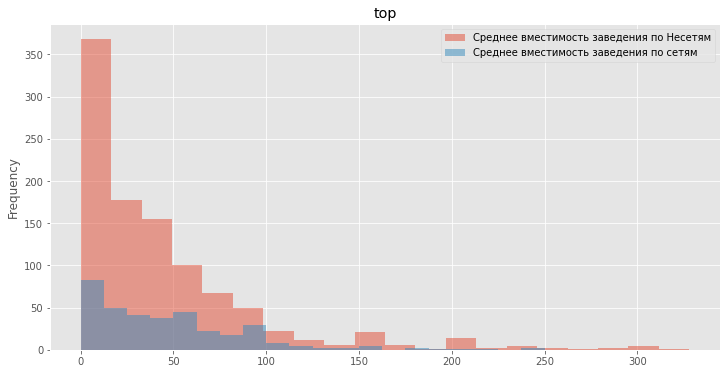

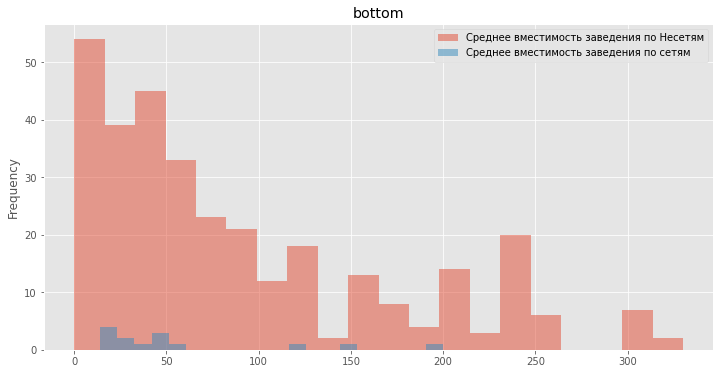

In [30]:
# строим гистограммы распределению кол-ва посадочных мест в заведениях топовых улиц и пустых улиц

# добавляем столбец со статусом улицы
df_actual_top['top'] = 'top'
df_actual_bottom['top'] = 'bottom'


# объединяем заполненные и пустые улицы
frames = [df_actual_top,df_actual_bottom]
df_actual_top_bottom = pd.concat(frames)

types = ['top','bottom']

for type in types:
   
    df_non_chain = df_actual_top_bottom[df_actual_top_bottom['chain']=='нет'].pivot_table(index=['id','top','object_type'], values='number',aggfunc='median').reset_index()
    df_chain = df_actual_top_bottom[df_actual_top_bottom['chain']=='да'].pivot_table(index=['id','top','object_type'], values='number',aggfunc='median').reset_index()
    df_non_chain = df_non_chain[df_non_chain['top']==type]
    df_chain = df_chain[df_chain['top']==type]
    
    ax1= df_non_chain.plot(kind='hist',y='number',alpha=0.5,bins=20,figsize=(12,6),label='Среднее вместимость заведения по Несетям')
    df_chain.plot(kind='hist',y='number',alpha=0.5,bins=20,figsize=(12,6),label='Среднее вместимость заведения по сетям',ax=ax1)
    plt.title(type)
    plt.show()
    


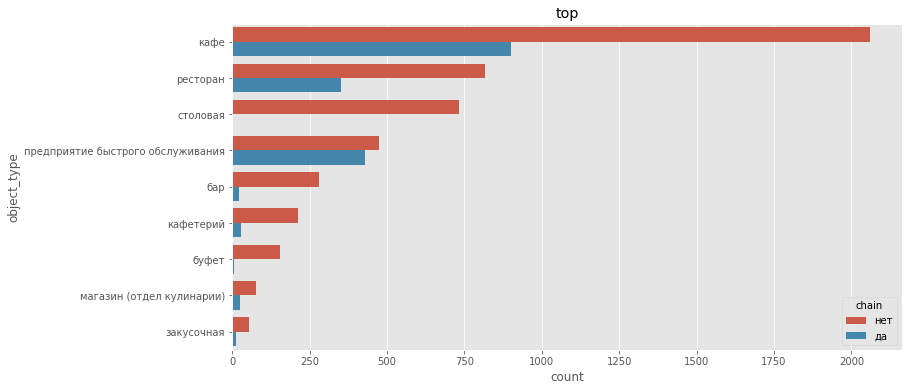

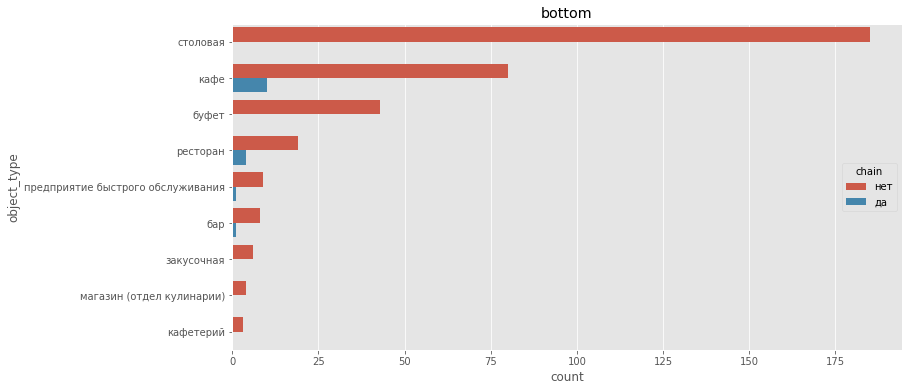

In [31]:
cats = ['top','bottom']

for cat in cats:
   
    df_actual_top_bottom_type = df_actual_top_bottom[df_actual_top_bottom['top']==cat].groupby(['object_type','chain']).agg({'number':'count'}).reset_index()
    df_actual_top_bottom_type.columns=['object_type','chain','count']
    df_actual_top_bottom_type= df_actual_top_bottom_type.sort_values(by='count',ascending=False)
    plt.figure(figsize=(12,6))
     
    sns.barplot(x='count', y='object_type',data=df_actual_top_bottom_type,hue='chain').set_title(cat)
    #df_actual_top_bottom_type['chain'] = pd.Series(['M','F','M','F'])
    plt.show()

#### Вывод
     - Для улиц с большим кол-вом объектов заведений характерно:
     - наиболее часто встречающиеся заведение небольшого формата, вто время как  на пустых улицах вектор направлен в сторону          заведений большей вместимости
     - процент заведений сетевого формата выше
     - отличие в миксе, больший процент присутствия небольших по площади заведений:
       лидирующие позиции в миксе на топовых улицах у кафе, на свободных- у столовых;
       предприятия быстрого питания бытсрого обслуживания, уступающие по площади барам и буфетам
       представлены в большей степени нежели на свободных улицах, где они как раз идут после

### Презентация
https://drive.google.com/file/d/1lSvPYhxUwVTXMpl518DPyvxY1_yyOEy6/view?usp=sharing

## Вывод

- Выбранный вид заведения "кафе" несетевого формата является потенциально привлекательным по ряду причин:
    - это самый популярный вид заведения общественного питания
    - несетевой формат гораздо в большей степени представлен нежели сетевой
    - в среднем заведения несетового формата меньше по кол-ву посадочных мест, что означает меньшие вложения
    - заведение типа кафе в среднем по рынку рассчитаны на небольшое кол-во посадочных мест,30-для несетового формата, 35-для сеетвого
    - процентное соотношение сетевыз и несетевых форматов для типа кафе ведет к незначительному различию в кол-ве посадочных мест,
      следовательно к дальнейшем к более простому переходу на формат сети
   
- Возможность перехода на сетевой формат оптимальна:
    - данный тип заведения представлен значительной долей сетевых форматов, несмотря на приоритет несетевых
    - нет огромной разницы в средней вместимости сетевых и нет форматов
    
- Рекомендации по размещению:
    - данный вид наиболее востребован на улицах с большим кол-вом объектов общественного питания
    - в целом в данных районах более популярны заведения небольшие по площади
    - популярность сетевого формата на улицах с большим скоплением заведений нежели на свободных улицах также говорит в пользу становления сетью
        